In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from os import getcwd
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant
%matplotlib inline
from scipy.stats import linregress
import PbPMethods2 as pm2
base = getcwd() + '/'
folder = '/Users/muneebalam/Desktop/Imperial/BA report/'
figfolder = folder + 'Figures/'

Helper methods for forward selection

In [6]:
def get_adjr2(obj):
    return obj.rsquared_adj
def get_aic(obj):
    return obj.aic
def get_bic(obj):
    return obj.bic
def forward_select(X, y, reg_type=OLS, eval_metric=get_adjr2, comparison_metric=max, printresults=True,
                  no_constant=False, force_constant=True, robust=True):
    #add variables from X one-by-one, minimising or maximizing eval_metric.
    if not no_constant:
        X = add_constant(X)
    metrics = None
    models = None
    current_best_vars = set()
    if force_constant:
        current_best_vars.add('const')
    current_best_metric = 0
    while True:
        this_iter_metrics = {}
        this_iter_models = {}
        for var in X.columns:
            if var not in current_best_vars:
                tempset = [x for x in current_best_vars]
                tempset.append(var)
                tempset.sort()
                tempset = tuple(tempset)
                this_iter_metrics[tempset] = 0
                this_iter_models[tempset] = None
        for combo in this_iter_metrics:
            mod = reg_type(y, X[list(combo)])
            modresult = mod.fit()
            if robust:
                modresult = modresult.get_robustcov_results()
            this_iter_metrics[combo] = eval_metric(modresult)
            this_iter_models[combo] = modresult
        newmodel = False
        for combo in this_iter_models:
            if len(current_best_vars) == 0 or (comparison_metric(this_iter_metrics[combo], current_best_metric) 
                                               == this_iter_metrics[combo]):
                current_best_vars = set(combo)
                current_best_metric = this_iter_metrics[combo]
                newmodel = True
        if not newmodel:
            mod = reg_type(y, X[list(current_best_vars)])
            modresult = mod.fit()
            if robust:
                modresult = modresult.get_robustcov_results()
            return modresult
        if printresults:
            print('Metric = {0:.3f}'.format(current_best_metric), str(current_best_vars))
    if printresults:
        print('Done')
def optimize_r2_aic_bic(X, y, no_const_for_aic_bic=True, force_constant=False):
    r2mod = forward_select(X, y, OLS, get_adjr2, max, False, force_constant)
    aicmod = forward_select(X, y, OLS, get_aic, min, False, no_const_for_aic_bic, force_constant)
    bicmod = forward_select(X, y, OLS, get_bic, min, False, no_const_for_aic_bic, force_constant)
    print('Item\t\tR2mod\tAICmod\tBICmod')
    print('Params:\t\t{0:d}\t{1:d}\t{2:d}'.format(
            len(r2mod.params), len(aicmod.params), len(bicmod.params)))
    print('Sig at 0.05:\t{0:d}\t{1:d}\t{2:d}'.format(
            len([x for x in r2mod.pvalues if x <= 0.05]), 
            len([x for x in aicmod.pvalues if x <= 0.05]), 
            len([x for x in bicmod.pvalues if x <= 0.05])))
    print('Sig at 0.1:\t{0:d}\t{1:d}\t{2:d}'.format(
            len([x for x in r2mod.pvalues if x <= 0.1]), 
            len([x for x in aicmod.pvalues if x <= 0.1]), 
            len([x for x in bicmod.pvalues if x <= 0.1])))
    print('Adj R2:\t\t{0:.3f}\t{1:.3f}\t{2:.3f}'.format(
            r2mod.rsquared_adj, aicmod.rsquared_adj, bicmod.rsquared_adj))
    print('AIC:\t\t{0:.1f}\t{1:.1f}\t{2:.1f}'.format(
            r2mod.aic, aicmod.aic, bicmod.aic))
    print('BIC\t\t{0:.1f}\t{1:.1f}\t{2:.1f}'.format(
            r2mod.bic, aicmod.bic, bicmod.bic))
    return (r2mod, aicmod, bicmod)  

Read in data and generate new columns

In [19]:
df = pd.read_csv(folder + 'data for sawsh.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)
df = df[df.TOI/3600 >= 20]

tm_mention_cols = [col for col in df.columns if col[:5] == 'TmAvg' and col[-7:] == 'mention']
indiv_mention_cols = [col for col in df.columns if col[-8:] == 'mention%']

interaction_cols = []
for col1 in tm_mention_cols:
    for col2 in indiv_mention_cols:
        colname = 'Tm {0:s}-{1:s}'.format(col1[col1.index(' ')+1:col1.index('_')], 
                                          col2[col2.index('_')+1:col2.rfind('_')])
        df[colname] = df[col1] * df[col2]
        interaction_cols.append(colname)

Separate training and test

In [20]:
odddf = df[df.OddGame] #training
evendf = df[~df.OddGame] #test

XlstF = ['iG60', 'iSv60', 'iM60', 'iB60', 'iA160', 'iA260',
        'TmAvg iG60', 'TmAvg iSv60', 'TmAvg iM60', 'TmAvg iB60', 'TmAvg iA160', 'TmAvg iA260']
XlstA = ['TmAvg GAON60', 'TmAvg SvAON60', 'TmAvg MAON60', 'TmAvg BAON60',
         'GAON60', 'SvAON60', 'MAON60', 'BAON60']
train_xf = add_constant(odddf[XlstF])
train_xa = add_constant(odddf[XlstA])
train_yf = odddf['Out GFON60']
train_ya = odddf['Out GAON60']

test_xf = add_constant(evendf[XlstF])
test_xa = add_constant(evendf[XlstA])
test_yf = evendf['Out GFON60']
test_ya = evendf['Out GFON60']

In [21]:
selected_vars = ['const', 'iG60', 'TmAvg iA160', 'iA160', 'iM60', 'iA260', 'TmAvg iB60']
ols = OLS(train_yf, train_xf[selected_vars])
gfmod = ols.fit().get_robustcov_results()
print(gfmod.summary())

                            OLS Regression Results                            
Dep. Variable:             Out GFON60   R-squared:                       0.525
Model:                            OLS   Adj. R-squared:                  0.517
Method:                 Least Squares   F-statistic:                     81.40
Date:                Thu, 01 Sep 2016   Prob (F-statistic):           1.23e-62
Time:                        16:01:20   Log-Likelihood:                -144.32
No. Observations:                 345   AIC:                             302.6
Df Residuals:                     338   BIC:                             329.5
Df Model:                           6                                         
Covariance Type:                  HC1                                         
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
const          -0.2936      0.140     -2.103      

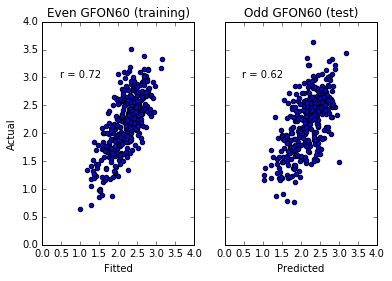

In [22]:
fig, axes = plt.subplots(1, 2, sharey=True)
axes[0].scatter(gfmod.fittedvalues, train_yf)
axes[0].set_xlabel('Fitted')
axes[0].set_ylabel('Actual')
axes[0].set_title('Even GFON60 (training)')
axes[0].set_xlim(0, 4)
axes[0].set_ylim(0, 4)
r = linregress(gfmod.fittedvalues, train_yf)[2]
axes[0].annotate('r = {0:.2f}'.format(r), xy=(1, 3), ha='center')

pred = gfmod.predict(test_xf[selected_vars])
axes[1].scatter(pred, test_yf)
axes[1].set_xlabel('Predicted')
axes[1].set_title('Odd GFON60 (test)')
axes[1].set_xlim(0, 4)
axes[1].set_ylim(0, 4)
r = linregress(pred, test_yf)[2]
axes[1].annotate('r = {0:.2f}'.format(r), xy=(1, 3), ha='center')

In [23]:
selected_vars = ['const', 'GAON60', 'TmAvg MAON60']
ols = OLS(train_ya, train_xa[selected_vars])
gamod = ols.fit().get_robustcov_results()
print(gamod.summary())

                            OLS Regression Results                            
Dep. Variable:             Out GAON60   R-squared:                       0.123
Model:                            OLS   Adj. R-squared:                  0.118
Method:                 Least Squares   F-statistic:                     23.08
Date:                Thu, 01 Sep 2016   Prob (F-statistic):           3.96e-10
Time:                        16:01:21   Log-Likelihood:                -185.66
No. Observations:                 345   AIC:                             377.3
Df Residuals:                     342   BIC:                             388.9
Df Model:                           2                                         
Covariance Type:                  HC1                                         
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
const            0.7571      0.261      2.898   

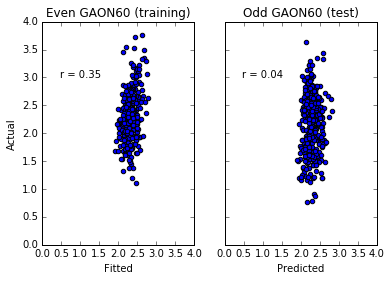

In [24]:
fig, axes = plt.subplots(1, 2, sharey=True)
axes[0].scatter(gamod.fittedvalues, train_ya)
axes[0].set_xlabel('Fitted')
axes[0].set_ylabel('Actual')
axes[0].set_title('Even GAON60 (training)')
axes[0].set_xlim(0, 4)
axes[0].set_ylim(0, 4)
r = linregress(gamod.fittedvalues, train_ya)[2]
axes[0].annotate('r = {0:.2f}'.format(r), xy=(1, 3), ha='center')

pred = gamod.predict(test_xa[selected_vars])
axes[1].scatter(pred, test_ya)
axes[1].set_xlabel('Predicted')
axes[1].set_title('Odd GAON60 (test)')
axes[1].set_xlim(0, 4)
axes[1].set_ylim(0, 4)
r = linregress(pred, test_ya)[2]
axes[1].annotate('r = {0:.2f}'.format(r), xy=(1, 3), ha='center')

Add skill interaction into the regression.

In [25]:
selected_vars = ['iG60', 'TmAvg iA160', 'iA160', 'iA260', 'TmAvg iB60', 'iM60']
selected_vars += ['Tm passing-shooting', 'Tm shooting-passing', 'Tm finesse-physical play', 'Tm physical play-finesse']
train_xf = add_constant(odddf[selected_vars])
train_yf = odddf['Out GFON60']

test_xf = add_constant(evendf[selected_vars])
test_yf = evendf['Out GFON60']

In [26]:
ols = OLS(train_yf, train_xf)
gfmod_chem = ols.fit().get_robustcov_results()
print(gfmod_chem.summary())

                            OLS Regression Results                            
Dep. Variable:             Out GFON60   R-squared:                       0.676
Model:                            OLS   Adj. R-squared:                  0.666
Method:                 Least Squares   F-statistic:                     60.95
Date:                Thu, 01 Sep 2016   Prob (F-statistic):           2.91e-69
Time:                        16:01:24   Log-Likelihood:                -78.376
No. Observations:                 345   AIC:                             178.8
Df Residuals:                     334   BIC:                             221.0
Df Model:                          10                                         
Covariance Type:                  HC1                                         
                               coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------
const                   

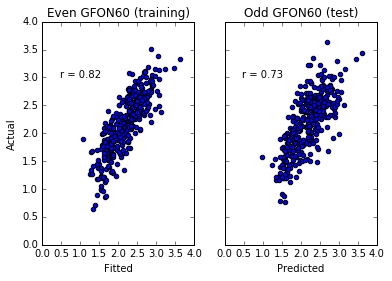

In [15]:
fig, axes = plt.subplots(1, 2, sharey=True)
axes[0].scatter(gfmod_chem.fittedvalues, train_yf)
axes[0].set_xlabel('Fitted')
axes[0].set_ylabel('Actual')
axes[0].set_title('Even GFON60 (training)')
axes[0].set_xlim(0, 4)
axes[0].set_ylim(0, 4)
r = linregress(gfmod_chem.fittedvalues, train_yf)[2]
axes[0].annotate('r = {0:.2f}'.format(r), xy=(1, 3), ha='center')

pred = gfmod_chem.predict(test_xf)
axes[1].scatter(pred, test_yf)
axes[1].set_xlabel('Predicted')
axes[1].set_title('Odd GFON60 (test)')
axes[1].set_xlim(0, 4)
axes[1].set_ylim(0, 4)
r = linregress(pred, test_yf)[2]
axes[1].annotate('r = {0:.2f}'.format(r), xy=(1, 3), ha='center')

Test to see if gfmod_chem is better than gfmod. Would like to use LR but shouldn't use that after robust. Use wald test.

In [274]:
gfmod_chem.compare_lm_test(gfmod)

(96.494189514856274, 5.4819313699198972e-20, 4.0)

### READ IN LINEMATE DATA ###

In [7]:
linematefile = base + 'linemates by game.csv'
def read_linemates():
    return pd.read_csv(linematefile)
linedf = read_linemates()
linedf.head()

,Season,Team,Name,Game,Linemate,TOI
0,2013,EDM,jesse joensuu,20003,jesse joensuu,631
1,2013,EDM,jesse joensuu,20003,boyd gordon,553
2,2013,EDM,jesse joensuu,20003,taylor hall,33
3,2013,EDM,jesse joensuu,20003,jordan eberle,99
4,2013,EDM,jesse joensuu,20003,nail yakupov,540


### SUM OVER ALL GAMES IN THAT SEASON AND DROP NAME=LINEMATE ROWS ###

In [8]:
linedf = linedf.groupby(['Season', 'Team', 'Name', 'Linemate']).sum()
linedf.reset_index(inplace=True)
linedf['Dup'] = linedf['Name'] == linedf['Linemate']
linedf = linedf[~linedf['Dup']]
linedf.drop(['Game', 'Dup'], axis=1, inplace=True)
linedf.head()

,Season,Team,Name,Linemate,TOI
1,2013,ANA,andrew cogliano,corey perry,2021
2,2013,ANA,andrew cogliano,daniel winnik,34212
3,2013,ANA,andrew cogliano,david steckel,295
4,2013,ANA,andrew cogliano,devante smith-pelly,3515
5,2013,ANA,andrew cogliano,dustin penner,544


### READ IN INDIVIDUAL STATS ###

In [9]:
toifile = base + 'toi by game.csv'
def read_toi():
    return pd.read_csv(toifile)

rtssfile = base + 'rtss by game.csv'
def read_rtss():
    return pd.read_csv(rtssfile)

boxcarfile = base + 'boxcars by game.csv'
def read_boxcars():
    return pd.read_csv(boxcarfile)

reboundfile = base + 'rebounds by game.csv'
def read_rebounds():
    return pd.read_csv(reboundfile)

gadatafile = base + 'shots against by game.csv'
def read_ga():
    return pd.read_csv(gadatafile)

def read_and_merge():
    boxcar = read_boxcars()
    rtss = read_rtss()
    toi = read_toi()
    rbd = read_rebounds()
    ga = read_ga()
    df = toi.merge(rtss, how='left', on=['Season', 'Team', 'Name', 'Game']).merge(
            boxcar, how='left', on=['Season', 'Team', 'Name', 'Game']).merge(
                rbd, how='left', on=['Season', 'Team', 'Name', 'Game']).merge(
                    ga, how='left', on=['Season', 'Team', 'Name', 'Game'])
    df['HRHelper'] = df['HR'].apply(lambda x: {'H': 0, 'R': 1}[x])
    df.fillna(value={'Hits': 0, 'Take': 0, 'Give': 0, 'PTake': 0, 'PDraw': 0, 'G': 0, 'Sv': 0, 'M': 0, 'B': 0,
                'A1': 0, 'A2': 0, 'GFON': 0, 'Rbd': 0}, inplace=True)
    df['RHits'] = df['Hits']*df['HRHelper']
    df['RGive'] = df['Give']*df['HRHelper']
    df['RTake'] = df['Take']*df['HRHelper']
    df['RTOI'] = df['TOI']*df['HRHelper']
    df['GameNum'] = df['GameNum'] - 1
    df['OddGame'] = df['GameNum'].apply(lambda x: x%2 == 1)
    return df
indivdf = read_and_merge()
indivdf.head()

,Season,Team,Name,Game,TOI,HR,GameNum,Hits,Take,Give,...,GAON,SvAON,MAON,BAON,HRHelper,RHits,RGive,RTake,RTOI,OddGame
0,2013,CBJ,ryan johansen,20018,537,H,1,0.929,0,0.864,...,0.000,2.062,1.031,2.066,0,0,0,0,0,True
1,2013,CBJ,blake comeau,20018,974,H,1,2.892,0,0.000,...,4.199,11.012,4.021,4.132,0,0,0,0,0,True
2,2013,CBJ,marian gaborik,20018,883,H,1,0.964,0,0.000,...,1.067,7.006,1.959,3.099,0,0,0,0,0,True
3,2013,CBJ,derek mackenzie,20018,561,H,1,0.000,0,0.000,...,2.065,6.068,1.031,0.000,0,0,0,0,0,True
4,2013,CBJ,mark letestu,20018,721,H,1,0.929,0,0.000,...,2.134,4.006,3.093,1.033,0,0,0,0,0,True


### GROUP BY TEAM/PLAYER AND CALCULATE RELEVANT INDIVIDUAL STATS ###

In [10]:
#need iG60, iA160, iA260, iM60, iB60, shooting, passing, physical play, and finesse
indivdf2 = indivdf.groupby(['Team', 'Name']).sum()
indivdf2.reset_index(inplace=True)
indivdf2.drop(['Season', 'Game', 'GameNum', 'HRHelper', 'RHits', 'RGive', 'RTake', 'RTOI', 'OddGame',
              'Sv', 'Hits', 'Take', 'Give', 'PTake', 'PDraw', 'GFON', 'Rbd', 'iFen', 'GAON',
              'SvAON', 'MAON', 'BAON'], axis=1,
              inplace=True)
indivdf2['iG60'] = indivdf2['G']*3600/indivdf2['TOI']
indivdf2['iA160'] = indivdf2['A1']*3600/indivdf2['TOI']
indivdf2['iA260'] = indivdf2['A2']*3600/indivdf2['TOI']
indivdf2['iM60'] = indivdf2['M']*3600/indivdf2['TOI']
indivdf2['iB60'] = indivdf2['B']*3600/indivdf2['TOI']
indivdf2.head()

,Team,Name,TOI,G,M,B,A1,A2,iG60,iA160,iA260,iM60,iB60
0,ANA,andrew cogliano,205449,34.131,147.201,153.161,34.761,24.918,0.598064,0.609103,0.436628,2.579344,2.683778
1,ANA,brandon pirri,5864,2.938,3.705,11.160,0.000,0.000,1.803683,0.000000,0.000000,2.274557,6.851296
2,ANA,carl hagelin,33343,3.940,32.477,25.047,1.882,5.700,0.425397,0.203197,0.615422,3.506499,2.704292
3,ANA,chris stewart,35993,6.766,30.274,23.611,5.883,3.825,0.676732,0.588414,0.382574,3.027989,2.361559
4,ANA,chris wagner,14923,0.000,8.958,15.157,0.941,1.002,0.000000,0.227005,0.241721,2.161013,3.656450


In [11]:
skillfile = folder + 'skill pred.csv'
psdf = pd.read_csv(skillfile)
psdf = psdf[['Player', 'const', 'pred_passing_mention%', 'pred_shooting_mention%', 
            'pred_finesse_mention%', 'pred_physical play_mention%']]
psdf.head()

,Player,const,pred_passing_mention%,pred_shooting_mention%,pred_finesse_mention%,pred_physical play_mention%
0,nazem kadri,1,0.272538,0.409826,0.636073,0.487518
1,jay rosehill,1,-0.110226,-0.053820,0.858568,1.354651
2,jujhar khaira,1,-0.083545,-0.904890,-0.508143,1.058793
3,darroll powe,1,NaN,NaN,-0.393702,0.684082
4,drew miller,1,0.216743,-0.093207,0.019078,0.585311


In [12]:
indivdf3 = indivdf2.merge(psdf, how='inner', left_on=['Name'], right_on=['Player'])
indivdf3.drop(['TOI', 'G', 'M', 'A1', 'A2', 'Player'], axis=1, inplace=True)
indivdf3.head()

,Team,Name,B,iG60,iA160,iA260,iM60,iB60,const,pred_passing_mention%,pred_shooting_mention%,pred_finesse_mention%,pred_physical play_mention%
0,ANA,andrew cogliano,153.161,0.598064,0.609103,0.436628,2.579344,2.683778,1,0.220434,0.365230,0.177619,0.539623
1,ANA,brandon pirri,11.160,1.803683,0.000000,0.000000,2.274557,6.851296,1,0.481900,0.491734,0.612657,0.252472
2,CHI,brandon pirri,16.895,0.915943,0.365911,0.569864,4.142255,3.284835,1,0.481900,0.491734,0.612657,0.252472
3,FLA,brandon pirri,80.937,0.840186,0.282163,0.235010,3.666527,3.401469,1,0.481900,0.491734,0.612657,0.252472
4,ANA,carl hagelin,25.047,0.425397,0.203197,0.615422,3.506499,2.704292,1,0.495924,0.579863,0.400442,0.348181


### MERGE SO LINEMATE DF HAS NECESSARY INDIV STATS ###

In [13]:
#need iG60, iA160, iA260, iM60, passing, shooting, finesse, and physical play for 'Name' player
cols_needed = ['iG60', 'iA160', 'iA260', 'iM60', 'pred_passing_mention%', 'pred_shooting_mention%',
              'pred_finesse_mention%', 'pred_physical play_mention%']
linedf2 = linedf.merge(indivdf3[cols_needed + ['Name', 'Team']], how='inner', on=['Team', 'Name'])
linedf2.rename(columns={col: 'Name ' + col for col in cols_needed}, inplace=True)
linedf2.head()

,Season,Team,Name,Linemate,TOI,Name iG60,Name iA160,Name iA260,Name iM60,Name pred_passing_mention%,Name pred_shooting_mention%,Name pred_finesse_mention%,Name pred_physical play_mention%
0,2013,ANA,andrew cogliano,corey perry,2021,0.598064,0.609103,0.436628,2.579344,0.220434,0.36523,0.177619,0.539623
1,2013,ANA,andrew cogliano,daniel winnik,34212,0.598064,0.609103,0.436628,2.579344,0.220434,0.36523,0.177619,0.539623
2,2013,ANA,andrew cogliano,david steckel,295,0.598064,0.609103,0.436628,2.579344,0.220434,0.36523,0.177619,0.539623
3,2013,ANA,andrew cogliano,devante smith-pelly,3515,0.598064,0.609103,0.436628,2.579344,0.220434,0.36523,0.177619,0.539623
4,2013,ANA,andrew cogliano,dustin penner,544,0.598064,0.609103,0.436628,2.579344,0.220434,0.36523,0.177619,0.539623


In [14]:
#need iA160, iB60, passing, shooting, finesse, and physical play for 'Linemate' player
cols_needed = ['iA160', 'iB60', 'pred_passing_mention%', 'pred_shooting_mention%',
              'pred_finesse_mention%', 'pred_physical play_mention%']
linedf3 = linedf2.merge(indivdf3[cols_needed + ['Name', 'Team']], how='inner', left_on=['Team', 'Linemate'],
                       right_on=['Team', 'Name'])
linedf3.rename(columns={col: 'Linemate ' + col for col in cols_needed}, inplace=True)
linedf3.drop('Name_y', axis=1, inplace=True)
linedf3.rename(columns={'Name_x': 'Name'}, inplace=True)
linedf3.head()

,Season,Team,Name,Linemate,TOI,Name iG60,Name iA160,Name iA260,Name iM60,Name pred_passing_mention%,Name pred_shooting_mention%,Name pred_finesse_mention%,Name pred_physical play_mention%,Linemate iA160,Linemate iB60,Linemate pred_passing_mention%,Linemate pred_shooting_mention%,Linemate pred_finesse_mention%,Linemate pred_physical play_mention%
0,2013,ANA,andrew cogliano,corey perry,2021,0.598064,0.609103,0.436628,2.579344,0.220434,0.365230,0.177619,0.539623,0.698967,3.451873,0.584341,1.058378,0.892738,0.25969
1,2014,ANA,andrew cogliano,corey perry,3327,0.598064,0.609103,0.436628,2.579344,0.220434,0.365230,0.177619,0.539623,0.698967,3.451873,0.584341,1.058378,0.892738,0.25969
2,2015,ANA,andrew cogliano,corey perry,2001,0.598064,0.609103,0.436628,2.579344,0.220434,0.365230,0.177619,0.539623,0.698967,3.451873,0.584341,1.058378,0.892738,0.25969
3,2013,ANA,daniel winnik,corey perry,2817,0.229637,1.054624,0.293229,2.683584,0.209489,0.046698,0.158871,0.402285,0.698967,3.451873,0.584341,1.058378,0.892738,0.25969
4,2013,ANA,david steckel,corey perry,279,0.000000,0.000000,0.000000,0.928732,NaN,NaN,-0.891804,1.512117,0.698967,3.451873,0.584341,1.058378,0.892738,0.25969


### GROUP BY NAME, LINEMATE. FILTER SEASON = 2015 AND TEAM = WSH ###

In [24]:
wsh2015 = linedf3[linedf3['Season'] == 2015]
wsh2015 = wsh2015[wsh2015['Team'] == 'WSH']
wsh2015.drop(['Season', 'Team'], axis=1, inplace=True)
wsh2015.head()

,Name,Linemate,TOI,Name iG60,Name iA160,Name iA260,Name iM60,Name pred_passing_mention%,Name pred_shooting_mention%,Name pred_finesse_mention%,Name pred_physical play_mention%,Linemate iA160,Linemate iB60,Linemate pred_passing_mention%,Linemate pred_shooting_mention%,Linemate pred_finesse_mention%,Linemate pred_physical play_mention%
29782,brooks laich,alex ovechkin,133,0.376825,0.309931,0.282043,1.645244,0.145318,-0.071870,0.003625,0.604746,0.358641,7.081757,0.114151,1.026468,0.369509,0.843254
29786,chris brown,alex ovechkin,18,0.719694,0.000000,0.000000,0.663862,-0.071678,-0.178448,0.059039,0.788920,0.358641,7.081757,0.114151,1.026468,0.369509,0.843254
29792,evgeny kuznetsov,alex ovechkin,20326,0.484278,0.964116,0.420320,2.563934,0.521973,0.387944,0.334595,0.243182,0.358641,7.081757,0.114151,1.026468,0.369509,0.843254
29795,jason chimera,alex ovechkin,493,0.693408,0.675001,0.305279,2.094088,0.400269,0.644785,0.204092,0.568825,0.358641,7.081757,0.114151,1.026468,0.369509,0.843254
29798,jay beagle,alex ovechkin,4095,0.650142,0.391959,0.237336,2.333315,0.426023,0.292279,0.150037,0.525368,0.358641,7.081757,0.114151,1.026468,0.369509,0.843254


### GET GFON FOR EACH PAIR OF FORWARDS AND MERGE ###

In [18]:
combos = {'Name': [], 'Linemate': [], 'GFON': []}
for line in pm2.read_team_pbp('WSH', 2015, types=['GOAL']):
    if pm2.get_acting_team(line) == 'WSH':
        fs = pm2.get_home_players(line, ['F'])
        for f1 in fs:
            for f2 in fs:
                if not f1 == f2:
                    combos['Name'].append(f1.lower())
                    combos['Linemate'].append(f2.lower())
                    combos['GFON'].append(adjust(line, 'WSH'))

In [19]:
gfcombos = pd.DataFrame.from_dict(combos)
gfcombos = gfcombos.groupby(['Linemate', 'Name']).sum()
gfcombos.reset_index(inplace=True)
gfcombos.head()

,Linemate,Name,GFON
0,alex ovechkin,andre burakovsky,5.637
1,alex ovechkin,evgeny kuznetsov,18.145
2,alex ovechkin,jay beagle,1.887
3,alex ovechkin,justin williams,8.553
4,alex ovechkin,marcus johansson,5.659


In [25]:
wshdf = wsh2015.merge(gfcombos, how='left', on=['Name', 'Linemate'])
wshdf['GFON'].fillna(0, inplace=True)
wshdf['Actual GFON60'] = wshdf['GFON'] * 3600 / wshdf['TOI']
wshdf['TOI (min)'] = wshdf['TOI'] / 60
wshdf['Predicted GFON60'] = (1.07 - 0.08*wshdf['Name iG60'] + 0.38*wshdf['Linemate iA160'] - 0.12*wshdf['Name iA160']
                            + 0.33*wshdf['Name iA260'] + 0.03*wshdf['Name iM60'] + 0.1*wshdf['Linemate iB60']
                            + 1.25*wshdf['Name pred_shooting_mention%']*wshdf['Linemate pred_passing_mention%']
                            + 1.75*wshdf['Linemate pred_shooting_mention%']*wshdf['Name pred_passing_mention%']
                            + wshdf['Name pred_physical play_mention%']*wshdf['Linemate pred_finesse_mention%']
                            + 0.44*wshdf['Linemate pred_physical play_mention%']*wshdf['Name pred_finesse_mention%'])
wshdf['Predicted GFON60 nochem'] = (-0.29 + 0.35*wshdf['Name iG60'] + 1.74*wshdf['Linemate iA160']
                                    + 0.33*wshdf['Name iA160'] + 0.09*wshdf['Name iA260']
                                    + 0.45*wshdf['Name iM60'] + 0.3*wshdf['Linemate iB60'])
wshdf.head()

,Name,Linemate,TOI,Name iG60,Name iA160,Name iA260,Name iM60,Name pred_passing_mention%,Name pred_shooting_mention%,Name pred_finesse_mention%,...,Linemate iB60,Linemate pred_passing_mention%,Linemate pred_shooting_mention%,Linemate pred_finesse_mention%,Linemate pred_physical play_mention%,GFON,Actual GFON60,TOI (min),Predicted GFON60,Predicted GFON60 nochem
0,brooks laich,alex ovechkin,133,0.376825,0.309931,0.282043,1.645244,0.145318,-0.071870,0.003625,...,7.081757,0.114151,1.026468,0.369509,0.843254,0.000,0.000000,2.216667,2.465140,3.458472
1,chris brown,alex ovechkin,18,0.719694,0.000000,0.000000,0.663862,-0.071678,-0.178448,0.059039,...,7.081757,0.114151,1.026468,0.369509,0.843254,0.000,0.000000,0.300000,2.035999,3.009193
2,evgeny kuznetsov,alex ovechkin,20326,0.484278,0.964116,0.420320,2.563934,0.521973,0.387944,0.334595,...,7.081757,0.114151,1.026468,0.369509,0.843254,18.145,3.213716,338.766667,3.182636,4.137817
3,jason chimera,alex ovechkin,493,0.693408,0.675001,0.305279,2.094088,0.400269,0.644785,0.204092,...,7.081757,0.114151,1.026468,0.369509,0.843254,0.000,0.000000,8.216667,3.038477,3.893820
4,jay beagle,alex ovechkin,4095,0.650142,0.391959,0.237336,2.333315,0.426023,0.292279,0.150037,...,7.081757,0.114151,1.026468,0.369509,0.843254,1.887,1.658901,68.250000,3.020509,3.886810


Linemate	TOI	PredGFON60	ActGFON60	NoChemPredGFON60
Laich          	2.2	1.820		0.000		3.735
Chimera        	8.2	2.585		0.000		4.348
Beagle         	68.2	2.283		1.887		3.543
Johansson      	114.2	2.439		5.659		4.301
Latta          	10.7	1.452		0.941		3.985
Backstrom      	900.3	2.464		37.270		4.080
Wilson         	47.0	1.506		1.882		4.193
Kuznetsov      	338.8	2.868		18.145		4.886
Brown          	0.3	1.580		0.000		3.499
Burakovsky     	35.0	2.761		5.637		4.134
Galiev         	7.3	1.628		0.000		4.605
Stephenson     	1.3	nan		0.000		2.759
Winnik         	2.5	1.897		0.000		3.168
Williams       	152.3	3.154		8.553		4.255
Richards       	17.4	2.112		0.000		3.531
Oshie          	1006.4	2.836		45.972		4.058
Sill           	2.5	0.496		0.914		3.836


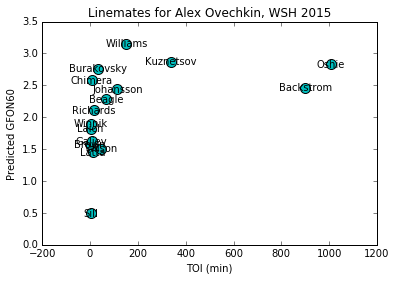

In [27]:
filtered = wshdf[wshdf['Name'] == 'alex ovechkin']
plt.scatter(filtered['TOI (min)'], filtered['Predicted GFON60'], s=100, c='c')
plt.xlabel('TOI (min)')
plt.ylabel('Predicted GFON60')
print('Linemate\tTOI\tPredGFON60\tActGFON60\tNoChemPredGFON60')
for l, x, yhat, y, yorg in zip(filtered['Linemate'], filtered['TOI (min)'], filtered['Predicted GFON60'],
                        filtered['GFON'], filtered['Predicted GFON60 nochem']):
    l2 = l[l.index(' ')+1:]
    l2 = l2[0].upper() + l2[1:]
    plt.annotate(l2, xy=(x, yhat), ha='center', va='center')
    print('{0:15s}\t{1:.1f}\t{2:.3f}\t\t{3:.3f}\t\t{4:.3f}'.format(l2, x, yhat, y, yorg))
plt.title('Linemates for Alex Ovechkin, WSH 2015')

In [132]:
kuz60s = 338/60
back60s = 900/60
kuzgf60 = 2.868
backgf60 = 2.464
kuzgfon = kuz60s * kuzgf60
backgfon = back60s * backgf60
kuzgfon_backtoi = kuzgf60 * back60s
backgfon_kuztoi = backgf60 * kuz60s
backgfon_real = 37.27
kuzgfon_real = 18.15
print('Projected: Kuz {0:.1f}\tBackstrom {1:.1f}'.format(kuzgfon, backgfon))
print('Actual: Kuz {0:.1f}\tBackstrom {1:.1f}'.format(kuzgfon_real, backgfon_real))
print('Couldve: Kuz {0:.1f}\tBackstrom {1:.1f}'.format(kuzgfon_backtoi, backgfon_kuztoi))

Projected: Kuz 16.2	Backstrom 37.0
Actual: Kuz 18.1	Backstrom 37.3
Couldve: Kuz 43.0	Backstrom 13.9


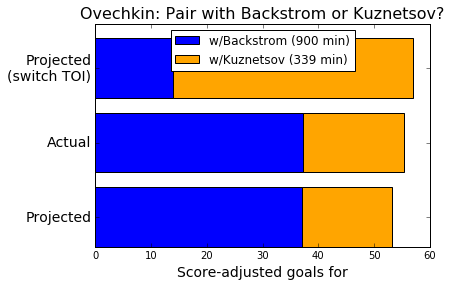

In [143]:
plt.title('Ovechkin: Pair with Backstrom or Kuznetsov?', size=16)
labs = ['Projected', 'Actual', 'Projected\n(switch TOI)']
index = [0, 1, 2]
back = [37, 37.3, 13.9]
kuz = [16.2, 18.1, 43]
plt.barh(index, back, color='b', label='w/Backstrom (900 min)')
plt.barh(index, kuz, left=back, color='orange', label='w/Kuznetsov (339 min)')
plt.yticks([x+0.4 for x in index], labs, size=14)
plt.xlabel('Score-adjusted goals for', size=14)
plt.legend(loc=9)

In [17]:
r = open(folder + 'event counts for weighting.csv')
ADJUST_INFO = {0: {}, 1: {}} #0 = home, 1 = road
for line in r.read().strip().split('\n')[1:]:
    line2 = line.split(',')
    if line2[1] not in ADJUST_INFO[0]:
        ADJUST_INFO[0][line2[1]] = {}
        ADJUST_INFO[1][line2[1]] = {}
    ADJUST_INFO[0][line2[1]][int(line2[0])] = float(line2[-2])
    ADJUST_INFO[1][line2[1]][int(line2[0])] = float(line2[-1])
r.close()

def adjust(info, perspective_team):
    #Perspective team will be checked against acting team
    score1, score2 = pm2.get_event_score(info)
    scorediff = score1 - score2
    if scorediff < -3:
        scorediff = -3
    elif scorediff > 3:
        scorediff = 3
    coefi = 0
    if info[0] == '@':
        coefi = 1
    if pm2.get_acting_team(info) == perspective_team:
        return ADJUST_INFO[coefi][pm2.get_event_type(info)][scorediff]
    else:
        return ADJUST_INFO[1 - coefi][pm2.get_event_type(info)][-1 * scorediff]

Kuz 16.2	Backstrom 37.0
Actual: Kuz 18.1	Backstrom 37.3
Couldve: Kuz 43.0	Backstrom 13.9

In [1]:
print('Coulve', (43+13.9))
print('Actual', (18.1+37.3))
print('Fitted', (16.2+37))

Coulve 56.9
Actual 55.4
Fitted 53.2


In [38]:
indivdf3.head()

,Team,Name,B,iG60,iA160,iA260,iM60,iB60,const,pred_passing_mention%,pred_shooting_mention%,pred_finesse_mention%,pred_physical play_mention%
0,ANA,andrew cogliano,153.161,0.598064,0.609103,0.436628,2.579344,2.683778,1,0.220434,0.365230,0.177619,0.539623
1,ANA,brandon pirri,11.160,1.803683,0.000000,0.000000,2.274557,6.851296,1,0.481900,0.491734,0.612657,0.252472
2,CHI,brandon pirri,16.895,0.915943,0.365911,0.569864,4.142255,3.284835,1,0.481900,0.491734,0.612657,0.252472
3,FLA,brandon pirri,80.937,0.840186,0.282163,0.235010,3.666527,3.401469,1,0.481900,0.491734,0.612657,0.252472
4,ANA,carl hagelin,25.047,0.425397,0.203197,0.615422,3.506499,2.704292,1,0.495924,0.579863,0.400442,0.348181


In [75]:
temp = indivdf2.merge(psdf, how='inner', left_on=['Name'], right_on=['Player'])
temp.drop(['G', 'M', 'A1', 'A2', 'Player'], axis=1, inplace=True)
temp = temp.dropna()
temp = temp[temp.TOI >= 60000]
temp.head()

,Team,Name,TOI,B,iG60,iA160,iA260,iM60,iB60,const,pred_passing_mention%,pred_shooting_mention%,pred_finesse_mention%,pred_physical play_mention%
0,ANA,andrew cogliano,205449,153.161,0.598064,0.609103,0.436628,2.579344,2.683778,1,0.220434,0.365230,0.177619,0.539623
3,FLA,brandon pirri,85661,80.937,0.840186,0.282163,0.235010,3.666527,3.401469,1,0.481900,0.491734,0.612657,0.252472
5,NYR,carl hagelin,150578,150.153,0.710614,0.384391,0.465510,3.048182,3.589839,1,0.495924,0.579863,0.400442,0.348181
13,ANA,corey perry,223154,213.972,1.246579,0.698967,0.308822,3.781699,3.451873,1,0.584341,1.058378,0.892738,0.259690
16,TOR,daniel winnik,84657,43.900,0.442595,0.606570,0.367029,1.939162,1.866827,1,0.209489,0.046698,0.158871,0.402285


In [76]:
temp['pass pctile'] = temp['pred_passing_mention%'].rank(pct=True)
temp['shoot pctile'] = temp['pred_shooting_mention%'].rank(pct=True)
temp.head()

,Team,Name,TOI,B,iG60,iA160,iA260,iM60,iB60,const,pred_passing_mention%,pred_shooting_mention%,pred_finesse_mention%,pred_physical play_mention%,pass pctile,shoot pctile
0,ANA,andrew cogliano,205449,153.161,0.598064,0.609103,0.436628,2.579344,2.683778,1,0.220434,0.365230,0.177619,0.539623,0.265664,0.533835
3,FLA,brandon pirri,85661,80.937,0.840186,0.282163,0.235010,3.666527,3.401469,1,0.481900,0.491734,0.612657,0.252472,0.661654,0.689223
5,NYR,carl hagelin,150578,150.153,0.710614,0.384391,0.465510,3.048182,3.589839,1,0.495924,0.579863,0.400442,0.348181,0.691729,0.776942
13,ANA,corey perry,223154,213.972,1.246579,0.698967,0.308822,3.781699,3.451873,1,0.584341,1.058378,0.892738,0.259690,0.832080,0.987469
16,TOR,daniel winnik,84657,43.900,0.442595,0.606570,0.367029,1.939162,1.866827,1,0.209489,0.046698,0.158871,0.402285,0.243108,0.235589


In [77]:
temp[temp.Name == 'nicklas backstrom']

,Team,Name,TOI,B,iG60,iA160,iA260,iM60,iB60,const,pred_passing_mention%,pred_shooting_mention%,pred_finesse_mention%,pred_physical play_mention%,pass pctile,shoot pctile
1139,WSH,nicklas backstrom,229016,125.191,0.605669,0.600608,0.507455,2.691229,1.967931,1,0.39137,0.167439,0.333892,0.267497,0.481203,0.343358


In [78]:
temp[temp.Name == 'evgeny kuznetsov']

,Team,Name,TOI,B,iG60,iA160,iA260,iM60,iB60,const,pred_passing_mention%,pred_shooting_mention%,pred_finesse_mention%,pred_physical play_mention%,pass pctile,shoot pctile
1133,WSH,evgeny kuznetsov,154057,108.939,0.484278,0.964116,0.42032,2.563934,2.545684,1,0.521973,0.387944,0.334595,0.243182,0.73183,0.558897


In [79]:
temp[temp.Name == 'alex ovechkin']

,Team,Name,TOI,B,iG60,iA160,iA260,iM60,iB60,const,pred_passing_mention%,pred_shooting_mention%,pred_finesse_mention%,pred_physical play_mention%,pass pctile,shoot pctile
1129,WSH,alex ovechkin,232789,457.932,1.107516,0.358641,0.281982,4.897082,7.081757,1,0.114151,1.026468,0.369509,0.843254,0.152882,0.982456


In [96]:
temp[temp.Name == 'justin williams']

,Team,Name,TOI,B,iG60,iA160,iA260,iM60,iB60,const,pred_passing_mention%,pred_shooting_mention%,pred_finesse_mention%,pred_physical play_mention%,pass pctile,shoot pctile
695,L.A,justin williams,149860,125.384,0.738834,0.481794,0.581463,3.118206,3.012027,1,0.688613,0.596566,0.544039,0.152875,0.928571,0.788221
696,WSH,justin williams,72894,55.314,0.801646,0.569479,0.374500,2.712174,2.731780,1,0.688613,0.596566,0.544039,0.152875,0.928571,0.788221


In [98]:
temp[temp.Name == 'tj oshie']

,Team,Name,TOI,B,iG60,iA160,iA260,iM60,iB60,const,pred_passing_mention%,pred_shooting_mention%,pred_finesse_mention%,pred_physical play_mention%,pass pctile,shoot pctile
1031,STL,tj oshie,134603,81.178,0.697491,0.880643,0.494334,2.721176,2.171131,1,0.540415,0.41964,0.428926,0.445158,0.763158,0.607769
1032,WSH,tj oshie,75659,57.284,0.723388,0.457262,0.501799,2.649837,2.725682,1,0.540415,0.41964,0.428926,0.445158,0.763158,0.607769


Linemate	TOI	PredGFON60	ActGFON60	NoChemPredGFON60
Ovechkin       	152.3	3.567		8.553		4.181
Laich          	27.3	1.678		1.943		2.723
Chimera        	159.2	2.885		6.541		3.336
Beagle         	99.7	2.249		4.781		2.530
Johansson      	422.9	2.164		19.224		3.288
Latta          	9.2	1.171		1.002		2.973
Backstrom      	201.1	2.176		7.592		3.068
Wilson         	3.3	1.590		0.914		3.180
Kuznetsov      	801.0	2.730		40.814		3.874
Brown          	0.2	1.423		0.000		2.486
Burakovsky     	505.0	2.409		23.930		3.122
Galiev         	5.8	2.090		0.000		3.593
Stephenson     	2.5	nan		0.000		1.747
Winnik         	17.7	1.716		0.000		2.155
Richards       	18.1	1.727		0.000		2.519
Oshie          	5.5	2.670		0.888		3.046
Sill           	2.6	0.616		0.000		2.824
Carey          	1.6	0.379		0.000		1.433
Collins        	0.3	0.052		0.000		1.433


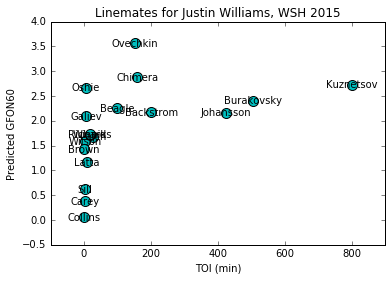

In [80]:
filtered = wshdf[wshdf['Name'] == 'justin williams']
plt.scatter(filtered['TOI (min)'], filtered['Predicted GFON60'], s=100, c='c')
plt.xlabel('TOI (min)')
plt.ylabel('Predicted GFON60')
print('Linemate\tTOI\tPredGFON60\tActGFON\tNoChemPredGFON60')
for l, x, yhat, y, yorg in zip(filtered['Linemate'], filtered['TOI (min)'], filtered['Predicted GFON60'],
                        filtered['GFON'], filtered['Predicted GFON60 nochem']):
    l2 = l[l.index(' ')+1:]
    l2 = l2[0].upper() + l2[1:]
    plt.annotate(l2, xy=(x, yhat), ha='center', va='center')
    print('{0:15s}\t{1:.1f}\t{2:.3f}\t\t{3:.3f}\t\t{4:.3f}'.format(l2, x, yhat, y, yorg))
plt.title('Linemates for Justin Williams, WSH 2015')

In [81]:
kuz60s = 801/60
back60s = 201/60
kuzgf60 = 2.73
backgf60 = 2.18
kuzgfon = kuz60s * kuzgf60
backgfon = back60s * backgf60
kuzgfon_backtoi = kuzgf60 * back60s
backgfon_kuztoi = backgf60 * kuz60s
backgfon_real = 7.6
kuzgfon_real = 40.8
print('Projected: Kuz {0:.1f}\tBackstrom {1:.1f}'.format(kuzgfon, backgfon))
print('Actual: Kuz {0:.1f}\tBackstrom {1:.1f}'.format(kuzgfon_real, backgfon_real))
print('Couldve: Kuz {0:.1f}\tBackstrom {1:.1f}'.format(kuzgfon_backtoi, backgfon_kuztoi))

Projected: Kuz 36.4	Backstrom 7.3
Actual: Kuz 40.8	Backstrom 7.6
Couldve: Kuz 9.1	Backstrom 29.1


Ovi totals: [53.2, 55.4, 56.9]
Williams totals: [43.699999999999996, 48.4, 38.2]
Combined totals: [96.9, 103.8, 95.1]


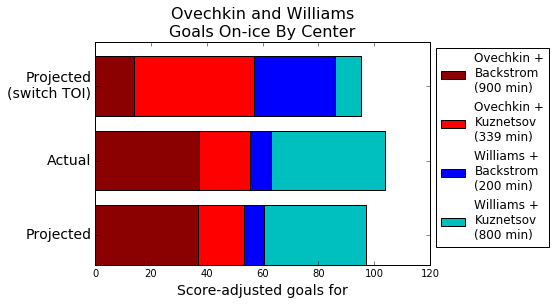

In [95]:
plt.title('Ovechkin and Williams\nGoals On-ice By Center', size=16)
labs = ['Projected', 'Actual', 'Projected\n(switch TOI)']
index = [0, 1, 2]
back_jw = [7.3, 7.6, 29.1]
kuz_jw = [36.4, 40.8, 9.1]
back_ao = [37, 37.3, 13.9]
kuz_ao = [16.2, 18.1, 43]
bump = [0, 0, 0]

plt.barh(index, back_ao, left=bump, color='darkred', label='Ovechkin +\nBackstrom\n(900 min)')
bump = [x+y for x, y in zip(bump, back_ao)]
plt.barh(index, kuz_ao, left=bump, color='r', label='Ovechkin +\nKuznetsov\n(339 min)')
bump = [x+y for x, y in zip(bump, kuz_ao)]
print('Ovi totals:', str(bump))

plt.barh(index, back_jw, left=bump, color='b', label='Williams +\nBackstrom\n(200 min)')
bump = [x+y for x, y in zip(bump, back_jw)]
plt.barh(index, kuz_jw, left=bump, color='c', label='Williams +\nKuznetsov\n(800 min)')
bump = [x+y for x, y in zip(bump, kuz_jw)]
print('Williams totals:', str([x+y for x, y in zip(back_jw, kuz_jw)]))
print('Combined totals:', str(bump))


plt.yticks([x+0.4 for x in index], labs, size=14)
plt.xlabel('Score-adjusted goals for', size=14)
plt.legend(loc=2, bbox_to_anchor=(1, 1))